# Implementação básica do algoritmo k-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans)

## Imports e Variáveis Globais

In [11]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 7

K = 5
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [12]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])
dataset

,d0,d1,d2,d3,d4,d5,d6
0,7.405113,9.619799,3.182069,7.717627,3.883290,9.860838,6.946283
1,8.377445,1.625159,7.268807,9.298369,8.666698,9.772695,1.090180
2,9.150446,7.078763,9.391062,4.274699,6.393613,7.716273,9.794752
3,7.784900,1.486616,8.705845,9.434079,3.493596,5.041758,8.647356
4,2.852204,5.345569,9.750391,9.467895,9.129888,6.111934,2.518524
...,...,...,...,...,...,...,...
99995,7.615074,5.232040,3.025786,2.801987,8.982537,1.894504,1.656834
99996,4.141202,8.668245,7.248411,9.481087,2.546157,9.698448,5.496123
99997,9.113272,5.442858,9.091991,2.776008,9.833393,7.157086,6.584761
99998,8.010159,8.675412,2.813514,8.110527,2.654479,3.479736,3.851761


## K-Means (CPU)

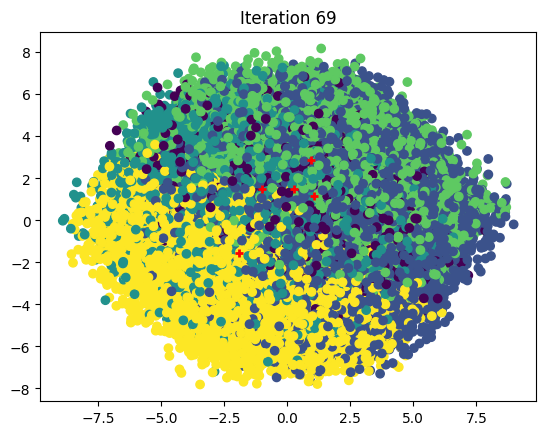

Iteration 69

Centroids:
         d0        d1        d2        d3        d4        d5        d6
0  4.405205  4.638180  2.738441  2.736219  5.285006  3.287277  3.001673
1  4.758709  4.840789  4.877134  4.532129  4.812302  8.364402  4.673906
2  5.414350  4.810690  3.884049  8.147711  4.404840  3.905766  3.711844
3  4.348838  4.670683  8.287327  3.931609  4.739116  3.545950  3.565605
4  4.737438  4.712535  4.536110  4.436842  4.825721  3.792384  8.365624

Distances:
               0          1          2          3          4
0      10.934517   7.150462   8.600285  11.237054   9.139121
1      12.066205   9.030804   9.548065  10.755016  12.543243
2      11.920108   8.595428  10.950202   9.440416   8.280587
3      11.831611   9.362890   8.249458   9.055942   8.091200
4      10.972254   8.964420   8.463145   7.902274  10.702794
...          ...        ...        ...        ...        ...
99995   5.306879   9.115148   7.972305   8.020011   8.910299
99996  11.703456   7.262026   8.354160   9.

In [13]:
def kMeansCPU(dataset:pd.DataFrame, k=3, maxIter=100, plotResults=False, debug=False):
    if plotResults:
        # Inicializando variáveis para exibição gráfica
        pca = PCA(n_components=2) # dois eixos no gráfico
        dataset_2D = pca.fit_transform(dataset)

    # Gerando centróides iniciais randomicamente
    centroids = pd.concat([(dataset.apply(lambda x: float(x.sample().iloc[0]))) for _ in range(k)], axis=1) # * Paralelizar isto provavelmente é irrelevante, visto que sempre teremos poucos centróides
    centroids_OLD = pd.DataFrame()

    iteration = 1

    while iteration <= maxIter and not centroids_OLD.equals(centroids):
        if plotResults or debug: clear_output(wait=True)
        if debug: debugStr = f'Iteration {iteration}\n\nCentroids:\n{centroids.T}\n\n'

        # Para cada datapoint, calcular distâncias entre ele e cada centróide; depois, encontrar o centróide mais próximo e salvar seu index
        distances = centroids.apply(lambda x: np.sqrt(((dataset - x) ** 2).sum(axis=1))) # ! Parte altamente paralelizável!
        if debug: debugStr += f'Distances:\n{distances}\n\n'
        closestCent = distances.idxmin(axis=1)
        del distances
        if debug: debugStr += f'Closest centroid index:\n{closestCent}\n\n'

        centroids_OLD = centroids
        centroids = dataset.groupby(closestCent).apply(lambda x: np.exp(np.log(x).mean())).T # ! Parte altamente paralelizável!

        if plotResults:
            # Plotando clusters
            centroids_2D = pca.transform(centroids.T)
            plt.title(f'Iteration {iteration}')
            plt.scatter(x=dataset_2D[:,0], y=dataset_2D[:,1], c=closestCent)
            plt.scatter(x=centroids_2D[:,0], y=centroids_2D[:,1], marker='+', linewidths=2, color='red')
            plt.show()

        if debug: print(debugStr)

        iteration += 1



kMeansCPU(dataset, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do K-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [117]:
# Imports
from os.path import exists as os_path_exists
from urllib.request import urlopen



# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



# Função auxiliar
def downloadFileIfNeeded(filePath, url):
    if not os_path_exists(filePath):
        with urlopen(url) as f:
            html = f.read().decode('utf-8')
        with open(filePath, 'w') as f:
            f.write(html)



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixnado dataset diretamente da internet, se necessário
downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [118]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# Sobrescrevendo a coluna do dataset pelos indexes obtidos
dataset['class'] = classFactorized[0]

print(dataset)

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

     sepalLen  sepalWid  petalLen  petalWid  class
0         5.1       3.5       1.4       0.2      0
1         4.9       3.0       1.4       0.2      0
2         4.7       3.2       1.3       0.2      0
3         4.6       3.1       1.5       0.2      0
4         5.0       3.6       1.4       0.2      0
..        ...       ...       ...       ...    ...
145       6.7       3.0       5.2       2.3      2
146       6.3       2.5       5.0       1.9      2
147       6.5       3.0       5.2       2.0      2
148       6.2       3.4       5.4       2.3      2
149       5.9       3.0       5.1       1.8      2

[150 rows x 5 columns]


## Rodando o K-Means

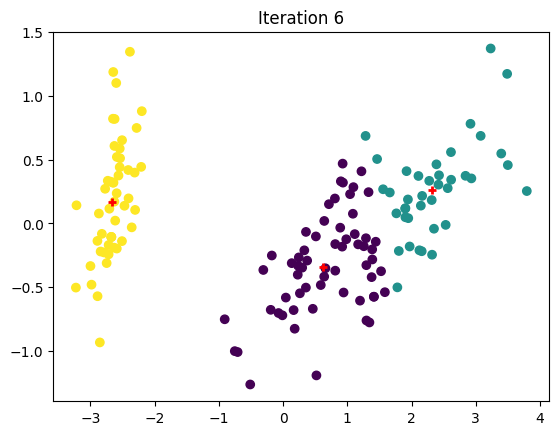

Iteration 6

Centroids:
   sepalLen  sepalWid  petalLen  petalWid
0  5.866563  2.725079  4.357356  1.404992
1  6.837288  3.064128  5.693547  2.031497
2  4.993841  3.396906  1.453739  0.223462

Distances:
            0         1         2
0    3.374327  4.999708  0.159174
1    3.347803  5.054317  0.412042
2    3.519354  5.219588  0.386394
3    3.370644  5.093816  0.495938
4    3.422628  5.044969  0.211479
..        ...       ...       ...
145  1.510393  0.581931  4.627634
146  0.946864  1.051293  4.230513
147  1.241333  0.602044  4.429064
148  1.566794  0.822928  4.619504
149  0.885579  1.135126  4.093819

[150 rows x 3 columns]

Closest centroid index:
0      2
1      2
2      2
3      2
4      2
      ..
145    1
146    0
147    1
148    1
149    0
Length: 150, dtype: int64




In [141]:
# Rodando kMeansCPU excluindo a coluna class
kMeansCPU(dataset.drop(['class'], axis=1), K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)